# Introduction

This is an attempt to present a case example of machine learning's application on time series data specific to predictive maintenance. Predictive maintenance is about predicting when an in-service machine or part of a machine will fail. This is a very relevant problem to many industrial scenarios to optimize the maintenance scheduling, minimize the downtime and maximizing the usage life of the machine. This example introduces a specific industry scenario that qualify for predictive maintenance. We will utilize time series data presented on Azure AI gallery https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2. The data represents measurements from 21 sensors in aircraft engine recorded over time. The main assumption is that the aircraft engine has a progressing degradation pattern, which is supposed to be reflected in sensor's data. Azure ML team has also attempted to solve this problem using built-in predictive maintenance template accomplishing three tasks.

- Predict the remaining useful life (RUL) using multiclass logistic regression.
- Predict if an asset will fail within certain time window. (Binary classification)
- Predict if an asset will two connecting time windows let's say either within w0 cycles or within w1 and w0 cycles where w1 > w0. (Multi-class classification)

However, initial checks reveals the the data is time non-stationary and therefore we believe RNN network are better suited methods to capture temporal dynamics. RNNs'networks are kind of neural networks distinguished by their memory used to remember important patterns from the input sequences to predict what's coming next. We will specifically use a special kind of RNN netwrok called long short term memory (LSTM). LSTM has the capability to learn long term patterns. LSTM can be computationally be more expensive but more accurate then other RNNs e.g. GRU. However in cases execution time is not an issue, LSTM is recommended. Further, evalualtion metrics shows better results while using LSTM compare to Azure AI gallery's predictive maintenance templates.

In [2]:
import keras
import wget
import pandas as pd
import seaborn as sns
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from helpers import gen_sequence, gen_labels, r2_keras
from keras.callbacks import History
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.utils import to_categorical

In [3]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.models import Sequential

import os.path

### Import data
The input data consists of "PM_train.txt", "PM_test.txt", and "PM_truth.txt".

The training data consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. Each engine is assumed to start with different degrees of initial wear and manufacturing variation, and this information is unknown to the user. In this simulated data, the engine is assumed to be operating normally at the start of each time series. It starts to degrade at some point during the series of the operating cycles. The degradation progresses and grows in magnitude. When a predefined threshold is reached, then the engine is considered unsafe for further operation. In other words, the last cycle in each time series can be considered as the failure point of the corresponding engine. Taking the sample training data shown in the following table as an example, the engine with id=1 fails at cycle 192, and engine with id=2 fails at cycle 287.

The testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs (in other words, the last time period does NOT represent the failure point). Taking the sample testing data shown in the following table as an example, the engine with id=1 runs from cycle 1 through cycle 31. It is not shown how many more cycles this engine can last before it fails.

The ground truth data provides the number of remaining working cycles for the engines in the testing data. Taking the sample ground truth data shown in the following table as an example, the engine with id=1 in the testing data can run another 112 cycles before it fails.

Apart from sensors data we also have three features setting1, setting2 and setting3 representing some sort of setting parameters.

In [4]:
if (os.path.isfile('PM_train.txt') == False):
    wget.download('http://azuremlsamples.azureml.net/templatedata/PM_train.txt')     
if (os.path.isfile('PM_test.txt') == False): 
    wget.download('http://azuremlsamples.azureml.net/templatedata/PM_test.txt') 
if (os.path.isfile('PM_truth.txt') == False):
    wget.download('http://azuremlsamples.azureml.net/templatedata/PM_truth.txt') 

# Load train, test and ground truth data

train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                      's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                      's15', 's16', 's17', 's18', 's19', 's20', 's21']


test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                      's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                      's15', 's16', 's17', 's18', 's19', 's20', 's21']

truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
#truth_df.drop(truth_df.columns[[26, 27]], axis=1, inplace=True)
#truth_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
 #                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
  #                    's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [5]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Sensor should have non zero variance if it posseses hidden pattern with engine degradation. A sensor have zero variance across all enginer id's mean its either faulty or has no correlation with enginer degradation. We may choose to drop those sensors data.

In [6]:
var_group = train_df.groupby('id').var().reset_index()
#print(var_group.head())
var_group.sum()

id            5050.000000
cycle       374135.833333
setting1         0.000479
setting2         0.000008
setting3         0.000000
s1               0.000000
s2              21.645346
s3            3380.073686
s4            6695.408989
s5               0.000000
s6               0.000177
s7              63.259996
s8               0.344170
s9           32804.346724
s10              0.000000
s11              5.761178
s12             43.178846
s13              0.352568
s14          22489.617257
s15              0.120145
s16              0.000000
s17            212.330447
s18              0.000000
s19              0.000000
s20              2.799292
s21              1.002310
dtype: float64

<AxesSubplot:>

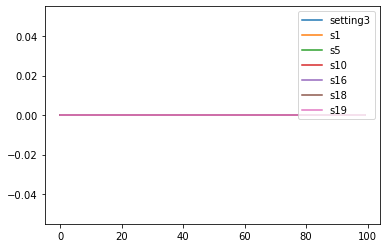

In [7]:
# Setting3 and sensor 1,5,10,16,18,19 have zero variances across all engines. 
var_group[['setting3','s1','s5','s10','s16','s18','s19']].plot(kind='line')
#(var_group==0).any(axis=0)

We choose to drop the corresponding columns

In [8]:
train_df = train_df.drop(['setting3','s1','s5','s10','s16','s18','s19'],axis=1)
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


Setting2 and s6 have way too low variance and may be dropped too. For now we will use but we will adress it again after we see the final results.

<AxesSubplot:>

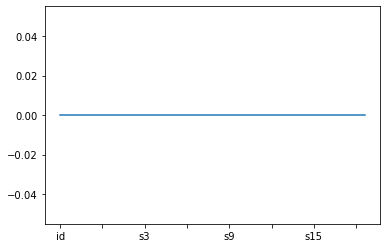

In [9]:
# No NaNs. 
train_df.isna().sum().plot(kind='line')

id            5050.000000
cycle       167708.500000
setting1         0.000485
setting2         0.000008
setting3         0.000000
s1               0.000000
s2              11.329447
s3            1954.111320
s4            2564.445618
s5               0.000000
s6               0.000277
s7              25.480034
s8               0.146950
s9            4760.482911
s10              0.000000
s11              1.918003
s12             15.958121
s13              0.146322
s14           3031.714945
s15              0.054525
s16              0.000000
s17            111.495693
s18              0.000000
s19              0.000000
s20              1.346277
s21              0.472412
dtype: float64


<AxesSubplot:>

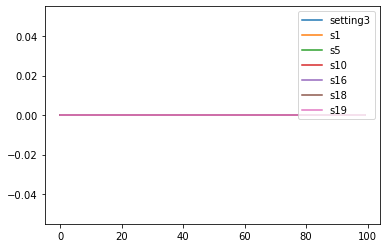

In [10]:
# Do the same for test data. We find the same senors data qualify again to be dropped.

var_group = test_df.groupby('id').var().reset_index()
#print(var_group.head())
print(var_group.sum())

# Setting3 and sensor 1,5,10,16,18,19 have zero variances across all engines. 
var_group[['setting3','s1','s5','s10','s16','s18','s19']].plot(kind='line')
#(var_group==0).any(axis=0)

<AxesSubplot:>

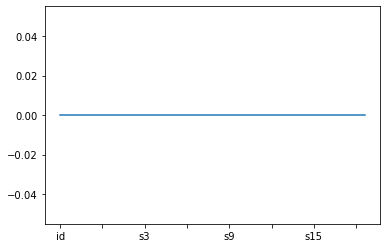

In [11]:
test_df = test_df.drop(['setting3','s1','s5','s10','s16','s18','s19'],axis=1)

# And No NaNs. 
test_df.isna().sum().plot(kind='line')

## Predictive maintenance questions and data labeling

Given the data, can we predict when an in service engine will fail?. This falls 
- To predict the remaining useful life (RUL) in-terms of cycles of the in-service engine.
- To predict if an in-service engine fails within next 'w1' cycles (binary classification). We will call it label1.
- To predict if an an engine will fail within between (w0,w1) cycles (multiclass classification). Note w0 < w1. we will call it label2.

### Training data preparation

remaining useful life RUL for a given engine will be calulated as the difference of max cycle of given engine-id and the current cycle. 
for label1 and label2 we pick values for w0 and w1 such that w0<w1. label1 will be equal to 1 if cycle is less then w1 else 0. label2 will be equal to label1 except when cycle < w0, in that case it will take value 2. 

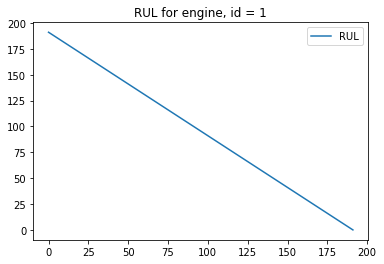

In [12]:
# calculate column 'RUL'
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df[train_df.id==1][['RUL']].plot(kind='line')
plt.title('RUL for engine, id = 1')
train_df.drop('max', axis=1, inplace=True)

In [13]:
# General label1 and label2 columns
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0,0


Normalize all training data except RUL, id and labels. cycle column will also be included in training and therefore will be normalized

In [14]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

### Preparing test data

Test must use ground truth data to calculate RUL and the two label columns as explained the remaining working cycles for a given engine is not included in test data but in ground truth data.

In [15]:
# MinMax Normalization similar to training data normalization
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [16]:
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [17]:
# Generate RUL and 2 lebel columns


# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [18]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [19]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,1.0,0.652174,0.212121,...,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,1.0,0.805153,0.166667,...,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,1.0,0.685990,0.227273,...,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,1.0,0.679549,0.196970,...,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,1.0,0.694042,0.166667,...,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,0.01108,138,0,0


# Modeling
LSTM uses time-series domain as length of time window to look back and extract feature out of the sequence of 21 sensors     data. This is an automatic feature engineering instead of manual feature engineering. Manual feature engineering is based on the domain knowledge which may add value in explaining the model results. LSTM will endcode the pattern if there is one between the the sensor data in the given time window and the failure. LSTM has the ability to remember from long term window sizes which is hard to achieve with traditional feature engineering.

We are choosing LSTM because we want to capture long pattens to achieve high accuracy. This will come at cost higher computation cost but it's not a point of concern at this point.

<br>
<br>
<br>
<br>
<br>



# <span style='color:Blue'> Multiclass classification problem </span>

To predict if an in-service engine fails within next 'w1' cycles (binary classification). 

In [20]:
# The first step is to define the time window, how far do we want to look into the past. 
# LSTM will use this to keep the patterns from this time window in its memory 
sequence_length = 50  
# here 50 represnts time in terms of the number of cycles

In [21]:
# pick the feature columns and generate sequences both for X and labels
sensor_cols = list(train_df.columns)
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print('Dimension of sequence array is:', seq_array.shape,' :Last index represents the total number of features and middle index of for the length of sequence')

Dimension of sequence array is: (15631, 50, 26)  :Last index represents the total number of features and middle index of for the length of sequence


In [22]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label2']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array3D = to_categorical(label_array)
print('Dimension of label array is:', label_array3D.shape)


Dimension of label array is: (15631, 3)


### LSTM Network
Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer
with 50 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense 
output layer with single unit and sigmoid activation since this is a binary classification problem.
We choose LSTM over GRU since accuracy is concerned and memory is not.

In [24]:
# build the network
history = History()
nb_features = seq_array.shape[2]
nb_out = label_array3D.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(
          units=50,
          return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(units=nb_out, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
#model.compile(optimizer='adam', metrics=['accuracy'])

print(model.summary())
print(nb_out)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 100)           50800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [25]:
# fit the network
model.fit(seq_array, label_array3D, epochs=20, batch_size=200, validation_split=0.1, verbose=1,
          callbacks = [history,keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/20
71/71 [==============================] - 9s 130ms/step - loss: 0.1986 - accuracy: 0.9247 - val_loss: 0.0744 - val_accuracy: 0.9674
Epoch 2/20
71/71 [==============================] - 9s 123ms/step - loss: 0.0593 - accuracy: 0.9770 - val_loss: 0.0393 - val_accuracy: 0.9808
Epoch 3/20
71/71 [==============================] - 8s 115ms/step - loss: 0.0473 - accuracy: 0.9812 - val_loss: 0.0355 - val_accuracy: 0.9872
Epoch 4/20
71/71 [==============================] - 8s 112ms/step - loss: 0.0300 - accuracy: 0.9886 - val_loss: 0.0234 - val_accuracy: 0.9910
Epoch 5/20
71/71 [==============================] - 8s 113ms/step - loss: 0.0309 - accuracy: 0.9870 - val_loss: 0.0383 - val_accuracy: 0.9853


In [26]:
# training metrics
scores = model.evaluate(seq_array, label_array3D, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 3s 40ms/step - loss: 0.0287 - accuracy: 0.9888
Accurracy: 0.988804280757904


79/79 [==============================] - 3s 37ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


Text(0.5, 442.81090909090915, 'Predicted Values')

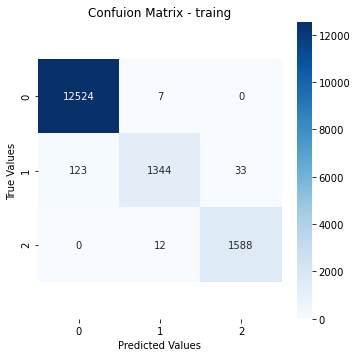

In [27]:
# make predictions and compute confusion matrix for training data
#threshold = 0.42
y_pred_1 = model.predict(seq_array,verbose=1, batch_size=200)
y_pred = np.argmax(y_pred_1,axis=-1)
      
#y_pred = np.where(y_pred > threshold,1,0)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix - traing')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
#print(cm)

In [28]:
# compute precision and recall
precision = precision_score(y_true, y_pred,average="macro")
recall = recall_score(y_true, y_pred,average="macro")
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9853255769843455 
 recall =  0.9626471284547655


#### Predict and evalaute using test data

In [29]:
# Generate sequence array from test data
seq_test = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_test = np.asarray(seq_test).astype(np.float32)
print('Dimension of sequence array:',seq_test.shape)

Dimension of sequence array: (93, 50, 26)


In [30]:
# Generate sequence label array
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_test = test_df.groupby('id')['label2'].nth(-1)[y_mask].values
label_test = label_test.reshape(label_test.shape[0],1).astype(np.float32)
label_test.shape
label_test3D = to_categorical(label_test)
print(np.unique(label_test))
print('Dimension of lebel array:', label_test3D.shape)

[0. 1. 2.]
Dimension of lebel array: (93, 3)


In [31]:
# test metrics
scores_test = model.evaluate(seq_test, label_test3D, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0260 - accuracy: 0.9892
Accurracy: 0.9892473220825195


1/1 [==============================] - 0s 997us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


Text(0.5, 442.81090909090915, 'Predicted Values')

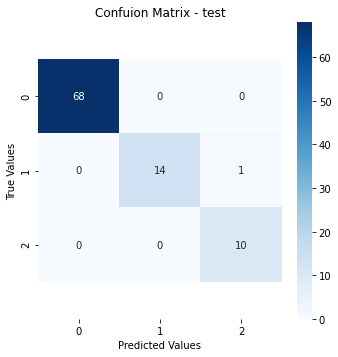

In [32]:
# make predictions and compute confusion matrix for training data
#threshold = 0.42
y_pred_1 = model.predict(seq_test,verbose=1, batch_size=200)
y_pred = np.argmax(y_pred_1,axis=-1)
      
#y_pred = np.where(y_pred > threshold,1,0)
y_true = label_test
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(cm, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix - test')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
#print(cm)

<br>
<br>
<br>



## <span style='color:green'> ----------Final comparison and results: Multiclass classification---------- </span>

In [33]:
# compute precision and recall
precision_test = precision_score(y_true, y_pred,average="macro")
recall_test = recall_score(y_true, y_pred,average="macro")
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision average macro: ', precision_test, '\n', 'Recall average macro: ', recall_test,'\n', 'F1-score average macro:', f1_test )

results_df = pd.DataFrame([[np.round(scores_test[1],2),np.round(precision_test,2),np.round(recall_test,2),np.round(f1_test,2)],
                          [0.92, 0.86, 0.84, 0.81]],
                         columns = ['Overall Accuracy', 'Precision avg \n (macro)    ', 'Recall avg \n(macro)   ', 'F1-score avg\n(macro)   '],
                         index = ['Axbit best model (LSTM)',
                                 'Azure Template Best Model (Neural network)'])
#print(results_df)
print(tabulate(results_df,headers='keys',tablefmt='psql'))




Precision average macro:  0.9696969696969697 
 Recall average macro:  0.9777777777777779 
 F1-score average macro: 0.9737206085753805
+--------------------------------------------+--------------------+------------------+---------------+----------------+
|                                            |   Overall Accuracy |   Precision avg  |   Recall avg  |   F1-score avg |
|                                            |                    |      (macro)     |    (macro)    |     (macro)    |
|--------------------------------------------+--------------------+------------------+---------------+----------------|
| Axbit best model (LSTM)                    |               0.99 |             0.97 |          0.98 |           0.97 |
| Azure Template Best Model (Neural network) |               0.92 |             0.86 |          0.84 |           0.81 |
+--------------------------------------------+--------------------+------------------+---------------+----------------+


Clearly LSTM achieves better accuracy, precision, recall and F1-Score